In [1]:
from collections import defaultdict
import scanpy as sc
import scanpy.external as sce
import scipy.io
# import scrublet as scr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
import seaborn as sns
import scvelo as scv
#import velocyto as vcy
from os import listdir
from os.path import isfile, join
import glob
from collections import Counter
import loompy as lp
import numba
import llvmlite

# import mnnpy
from matplotlib import colors

In [2]:
#Define a nice colour map for gene expression
colors2 = plt.cm.Reds(np.linspace(0, 1, 128))
colors3 = plt.cm.Greys_r(np.linspace(0.7,0.8,20))
colorsComb = np.vstack([colors3, colors2])
mymap = colors.LinearSegmentedColormap.from_list('my_colormap', colorsComb)

In [3]:
sc.settings.set_figure_params(dpi=80)
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()

scanpy==1.9.1 anndata==0.7.6 umap==0.5.1 numpy==1.19.2 scipy==1.7.1 pandas==1.3.3 scikit-learn==1.0 statsmodels==0.13.0rc0 python-igraph==0.8.3 louvain==0.7.0 leidenalg==0.8.3 pynndescent==0.5.4


In [4]:
sc.set_figure_params(dpi_save=1000)

## Read files

In [5]:
# d60 = sc.read('./write/cellranger_d60_concatenated.h5ad')

In [6]:
# d90 = sc.read('./write/cellranger_d90_concatenated.h5ad')

In [7]:
# d150 = sc.read('./write/cellranger_d150_concatenated.h5ad')

In [8]:
# d60.obs['sample'].cat.rename_categories({'S2': 'd60S2', 'S3': 'd60S3', 'S4': 'd60S4'}, inplace=True)

In [9]:
# d90.obs['sample'].cat.rename_categories({'S2': 'd90S2', 'S3': 'd90S3'}, inplace=True)

In [10]:
# d150.obs['sample'].cat.rename_categories({'S2': 'd150S2', 'S3': 'd150S3', 'S4': 'd150S4'}, inplace=True)

In [11]:
# # CREATE MERGED OBJECT
# d60.obs['age'] = '2M'
# d90.obs['age'] = '3M'
# d150.obs['age'] = '5M'

# adata = d60.concatenate(d90,d150,
#                         batch_key = 'day',
#                         batch_categories = ['d60','d90','d150']
#                         )

# # and delete individual datasets to save space
# del(d60)
# del(d90)
# del(d150)

In [12]:
# adata

In [13]:
# adata.obs

In [14]:
all_adata = './write/all_raw_concatenated.h5ad'

In [15]:
# adata.write(all_adata)

In [16]:
adata = sc.read(all_adata)

In [17]:
adata

AnnData object with n_obs × n_vars = 22425 × 33538
    obs: 'sample', 'batch', 'age', 'day'
    var: 'gene_ids', 'feature_types', 'genome'

## Process

In [18]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

print(adata.n_obs, adata.n_vars)

filtered out 171 cells that have less than 200 genes expressed
filtered out 9867 genes that are detected in less than 3 cells
22254 23671


In [19]:
# mitochondrial genes
adata.var['mt'] = adata.var_names.str.startswith('MT-') 
# ribosomal genes
adata.var['ribo'] = adata.var_names.str.startswith(("RPS","RPL"))
# hemoglobin genes.
adata.var['hb'] = adata.var_names.str.contains(("^HB[^(P)]"))

adata.var


gene_ids    feature_types  genome  n_cells     mt   ribo  \
AL627309.1  ENSG00000238009  Gene Expression  GRCh38       44  False  False   
AL669831.5  ENSG00000237491  Gene Expression  GRCh38     2005  False  False   
FAM87B      ENSG00000177757  Gene Expression  GRCh38       21  False  False   
LINC00115   ENSG00000225880  Gene Expression  GRCh38      879  False  False   
FAM41C      ENSG00000230368  Gene Expression  GRCh38      124  False  False   
...                     ...              ...     ...      ...    ...    ...   
AL592183.1  ENSG00000273748  Gene Expression  GRCh38      624  False  False   
AC007325.4  ENSG00000278817  Gene Expression  GRCh38     1135  False  False   
AC007325.2  ENSG00000277196  Gene Expression  GRCh38        7  False  False   
AC004556.1  ENSG00000276345  Gene Expression  GRCh38     1216  False  False   
AC240274.1  ENSG00000271254  Gene Expression  GRCh38     1460  False  False   

               hb  
AL627309.1  False  
AL669831.5  False  
FAM87B      False  
LINC00115   False  
FAM41C      False  
...           ...  
AL592183.1  False  
AC007325.4  False  
AC007325.2  False  
AC004556.1  False  
AC240274.1  False  

[23671 rows x 7 columns]

In [20]:
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt','ribo','hb'], percent_top=None, log1p=False, inplace=True)

In [21]:
sc.pp.calculate_qc_metrics(adata, inplace=True)

# we now have many additional data types in the obs slot:
adata

AnnData object with n_obs × n_vars = 22254 × 23671
    obs: 'sample', 'batch', 'age', 'day', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_mean_counts', 'log1p_total_counts'

In [22]:
mito_genes = adata.var_names.str.startswith('MT-')
# for each cell compute fraction of counts in mito genes vs. all genes
# the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)
adata.obs['percent_mt2'] = np.sum(
    adata[:, mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1
# add the total counts per cell as observations-annotation to adata
adata.obs['n_counts'] = adata.X.sum(axis=1).A1

In [23]:
adata

AnnData object with n_obs × n_vars = 22254 × 23671
    obs: 'sample', 'batch', 'age', 'day', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'percent_mt2', 'n_counts'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_mean_counts', 'log1p_total_counts'

**Plot QC**

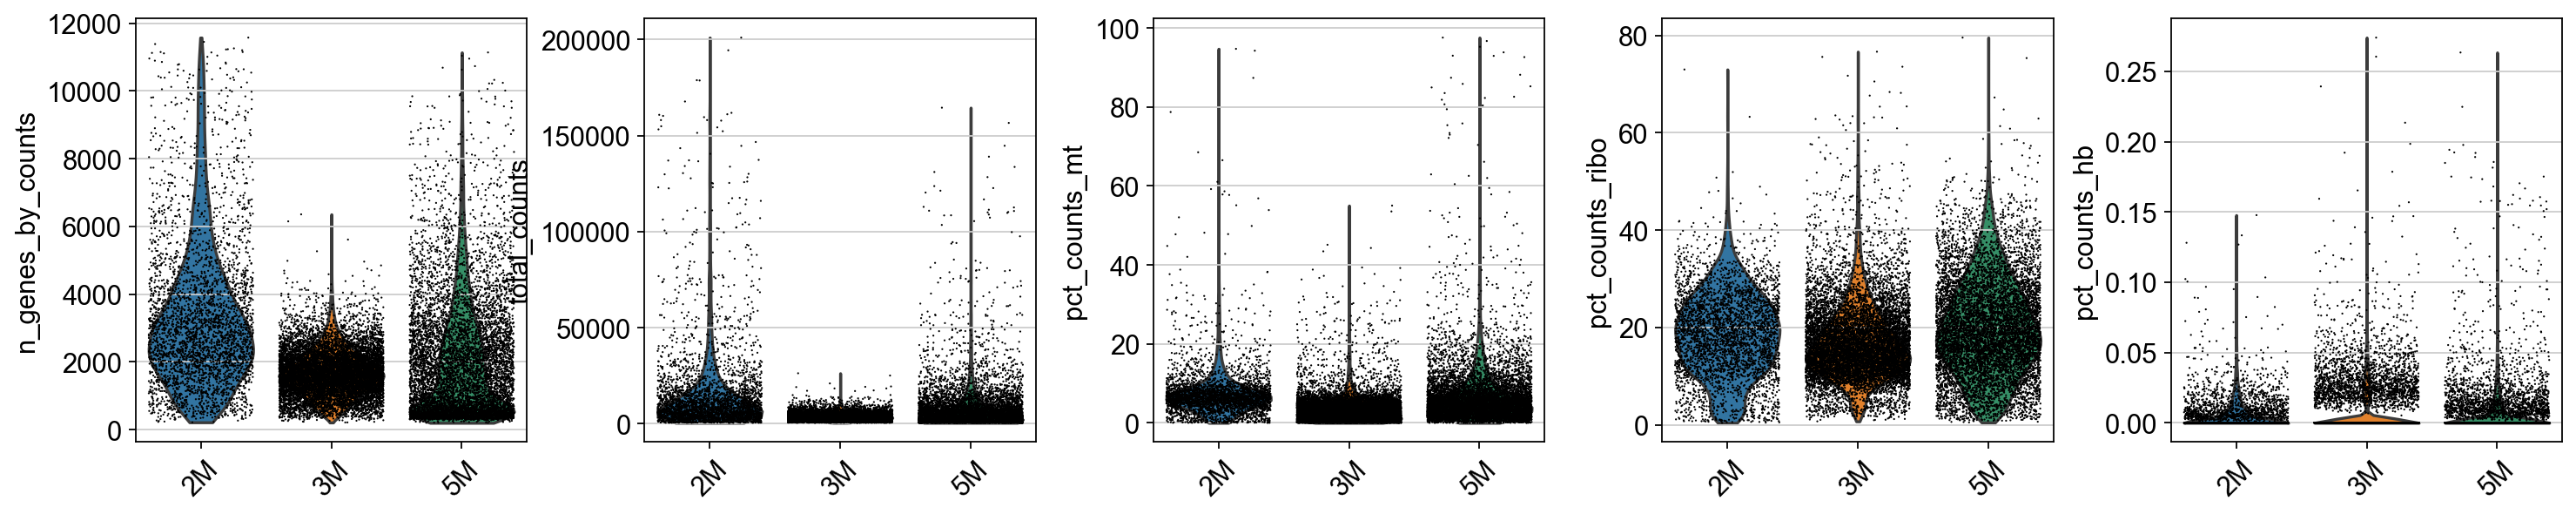

In [24]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt','pct_counts_ribo', 'pct_counts_hb'],
             jitter=0.4,
             groupby = 'age',
             rotation= 45)

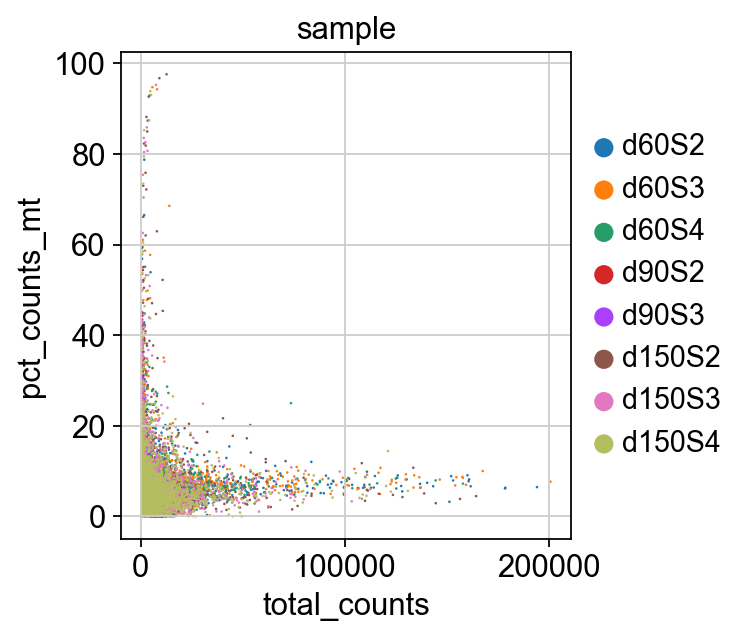

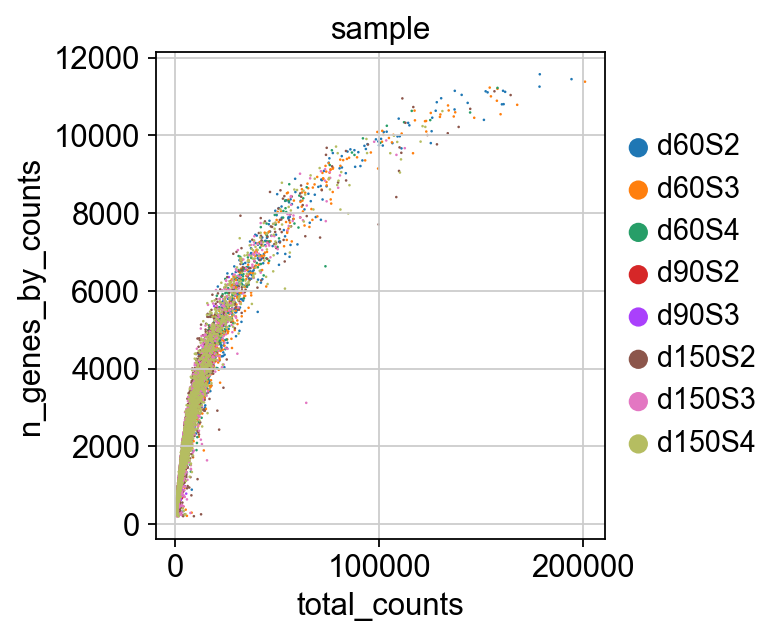

In [25]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt', color="sample")
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts', color="sample")
# sc.pl.scatter(adata, x='total_counts', y='pct_counts_ribo', color="sample")
# sc.pl.scatter(adata, x='pct_counts_mt', y='pct_counts_ribo', color="sample")

In [26]:
# Actually do the filtering

adata = adata[adata.obs['n_genes_by_counts'] < 5000, :]
adata = adata[adata.obs['n_genes_by_counts'] > 200, :]

adata = adata[adata.obs['pct_counts_mt'] < 8, :]
# adata = adata[adata.obs['pct_counts_mt'] > 0.02, :]

# adata = adata[adata.obs['pct_counts_ribo'] < 30, :]
# adata = adata[adata.obs['pct_counts_ribo'] > 0.05, :]

adata = adata[adata.obs['total_counts'] < 40000, :]
adata = adata[adata.obs['n_counts'] > 1000, :]

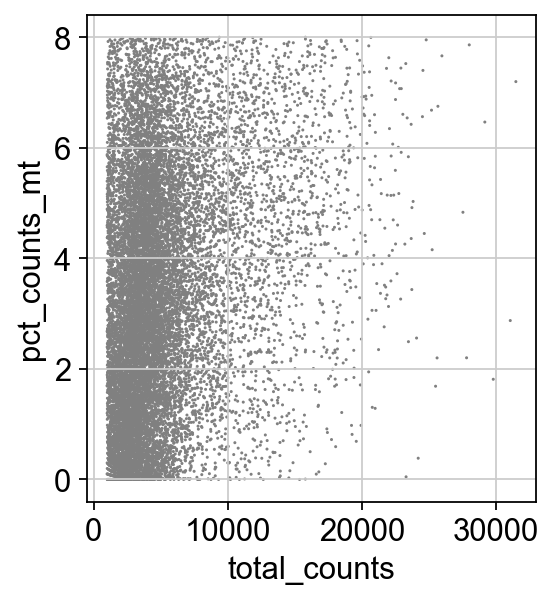

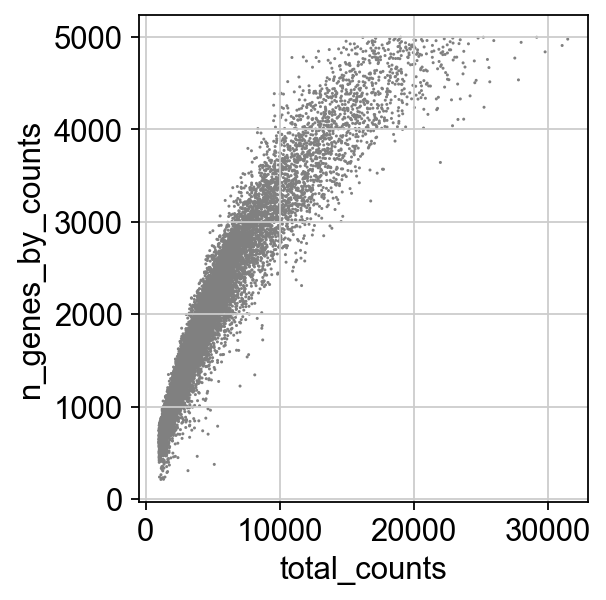

In [27]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

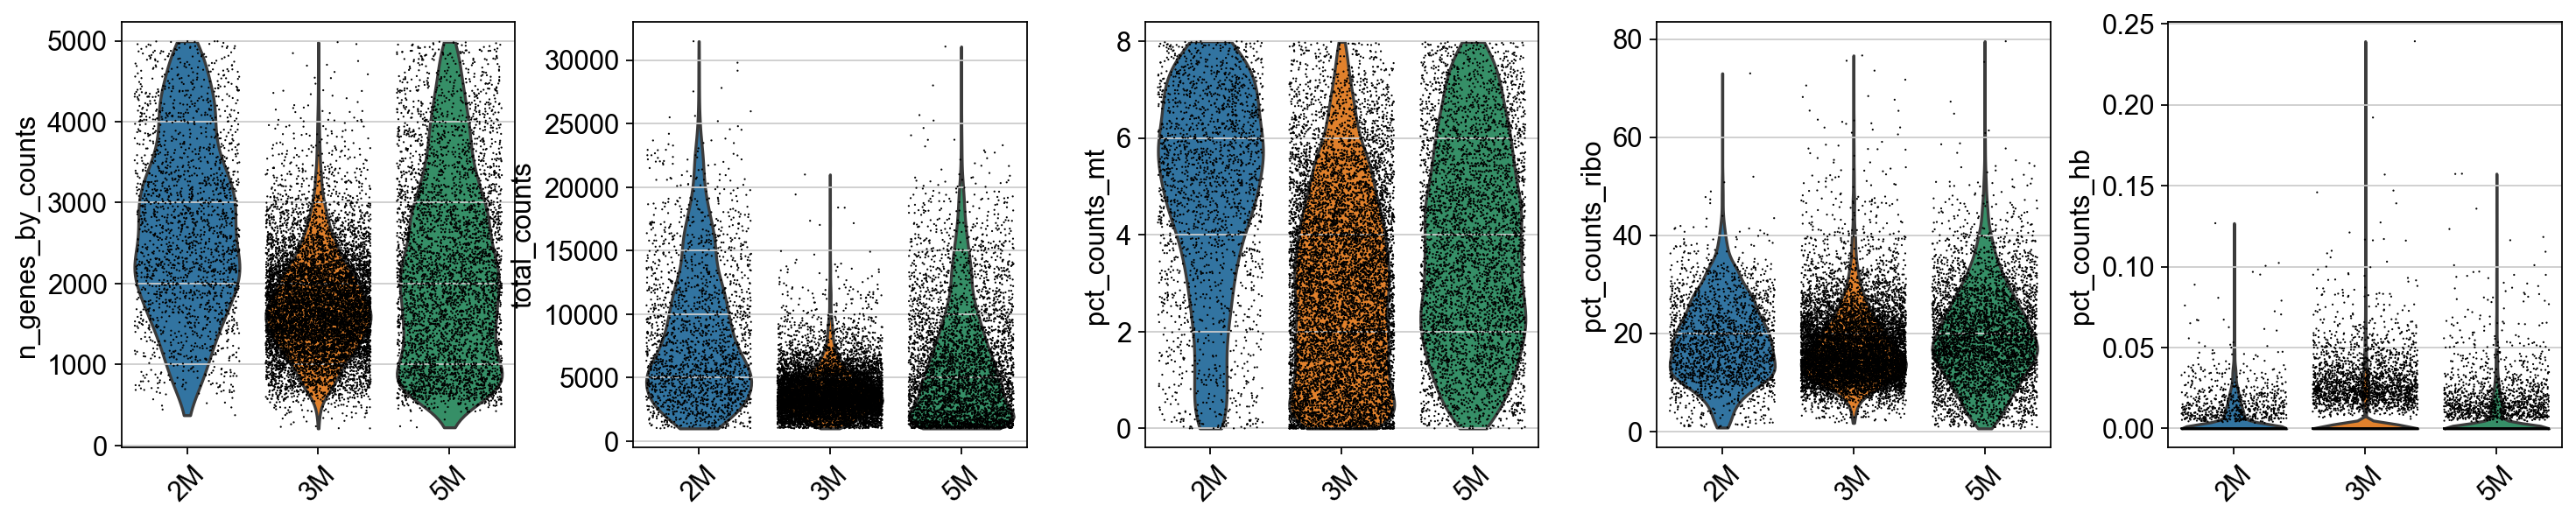

In [28]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt','pct_counts_ribo', 'pct_counts_hb'],
             jitter=0.4, groupby = 'age', rotation= 45)

normalizing counts per cell
    finished (0:00:00)


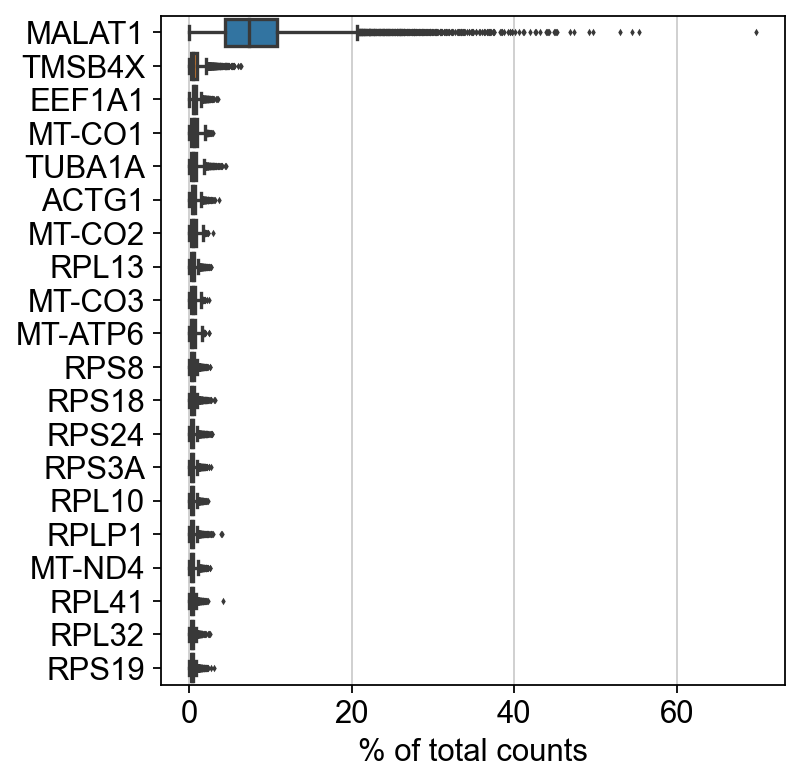

In [29]:
sc.pl.highest_expr_genes(adata, n_top=20)


In [30]:
# filtered_adata = './write/all_filtered.h5ad'

In [31]:
# adata.write(filtered_adata)

In [32]:
# adata = sc.read_h5ad(filtered_adata)

In [33]:
sc.pp.filter_genes(adata, min_counts=1)

filtered out 161 genes that are detected in less than 1 counts


In [34]:

# normalize to depth 10 000
sc.pp.normalize_total(adata, target_sum=1e4)

# logaritmize
sc.pp.log1p(adata)

adata.raw = adata

adata

normalizing counts per cell
    finished (0:00:00)


AnnData object with n_obs × n_vars = 16228 × 23510
    obs: 'sample', 'batch', 'age', 'day', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'percent_mt2', 'n_counts'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_mean_counts', 'log1p_total_counts', 'n_counts'
    uns: 'age_colors', 'sample_colors', 'log1p'

In [35]:
# with normalize_per_cell
#sc.pp.highly_variable_genes(adata, min_mean=1, max_mean=9, min_disp=0.7,n_top_genes=2000)


# with normalize_total
sc.pp.highly_variable_genes(adata,
                            min_mean=0.05, max_mean=3, min_disp=1.0,
                            #batch_key='batch',
                           )#n_top_genes=1000, flavor="cell_ranger")
var_genes_all = adata.var.highly_variable
print("Highly variable genes: %d"%sum(adata.var.highly_variable))

extracting highly variable genes
    finished (0:00:05)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
Highly variable genes: 663


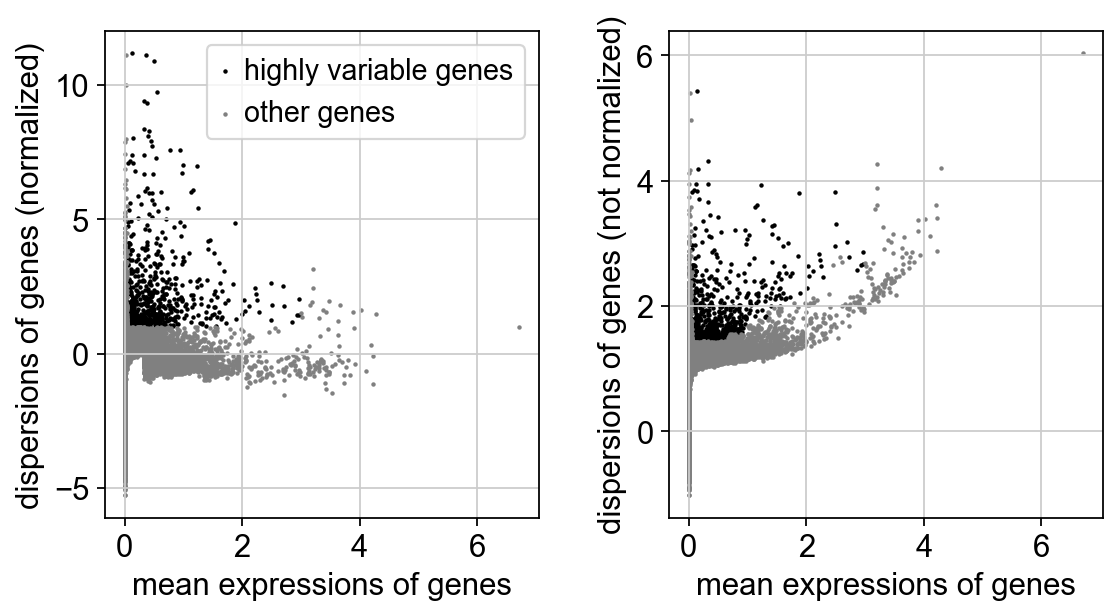

In [36]:
sc.pl.highly_variable_genes(adata)

In [37]:
cell_cycle_genes = [x.strip() for x in open('./regev_lab_cell_cycle_genes.txt')]
print(len(cell_cycle_genes))

# Split into 2 lists
s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]

cell_cycle_genes = [x for x in cell_cycle_genes if x in adata.var_names]
print(len(cell_cycle_genes))

97
94


In [38]:
sc.tl.score_genes_cell_cycle(adata, s_genes=s_genes, g2m_genes=g2m_genes)

calculating cell cycle phase
computing score 'S_score'
    finished: added
    'S_score', score of gene set (adata.obs).
    599 total control genes are used. (0:00:01)
computing score 'G2M_score'
    finished: added
    'G2M_score', score of gene set (adata.obs).
    472 total control genes are used. (0:00:00)
-->     'phase', cell cycle phase (adata.obs)


In [39]:
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])

regressing out ['total_counts', 'pct_counts_mt']
    sparse input is densified and may lead to high memory use


... storing 'phase' as categorical


    finished (0:19:11)


In [40]:
sc.pp.scale(adata, max_value=10)


In [41]:
adata

AnnData object with n_obs × n_vars = 16228 × 23510
    obs: 'sample', 'batch', 'age', 'day', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'percent_mt2', 'n_counts', 'S_score', 'G2M_score', 'phase'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_mean_counts', 'log1p_total_counts', 'n_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'age_colors', 'sample_colors', 'log1p', 'hvg'

In [42]:
scv.set_figure_params('scanpy')  # for beautified visualization

In [43]:
sc.tl.pca(adata, svd_solver='arpack', n_comps=50,
#           use_highly_variable = False 
         )

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:02)


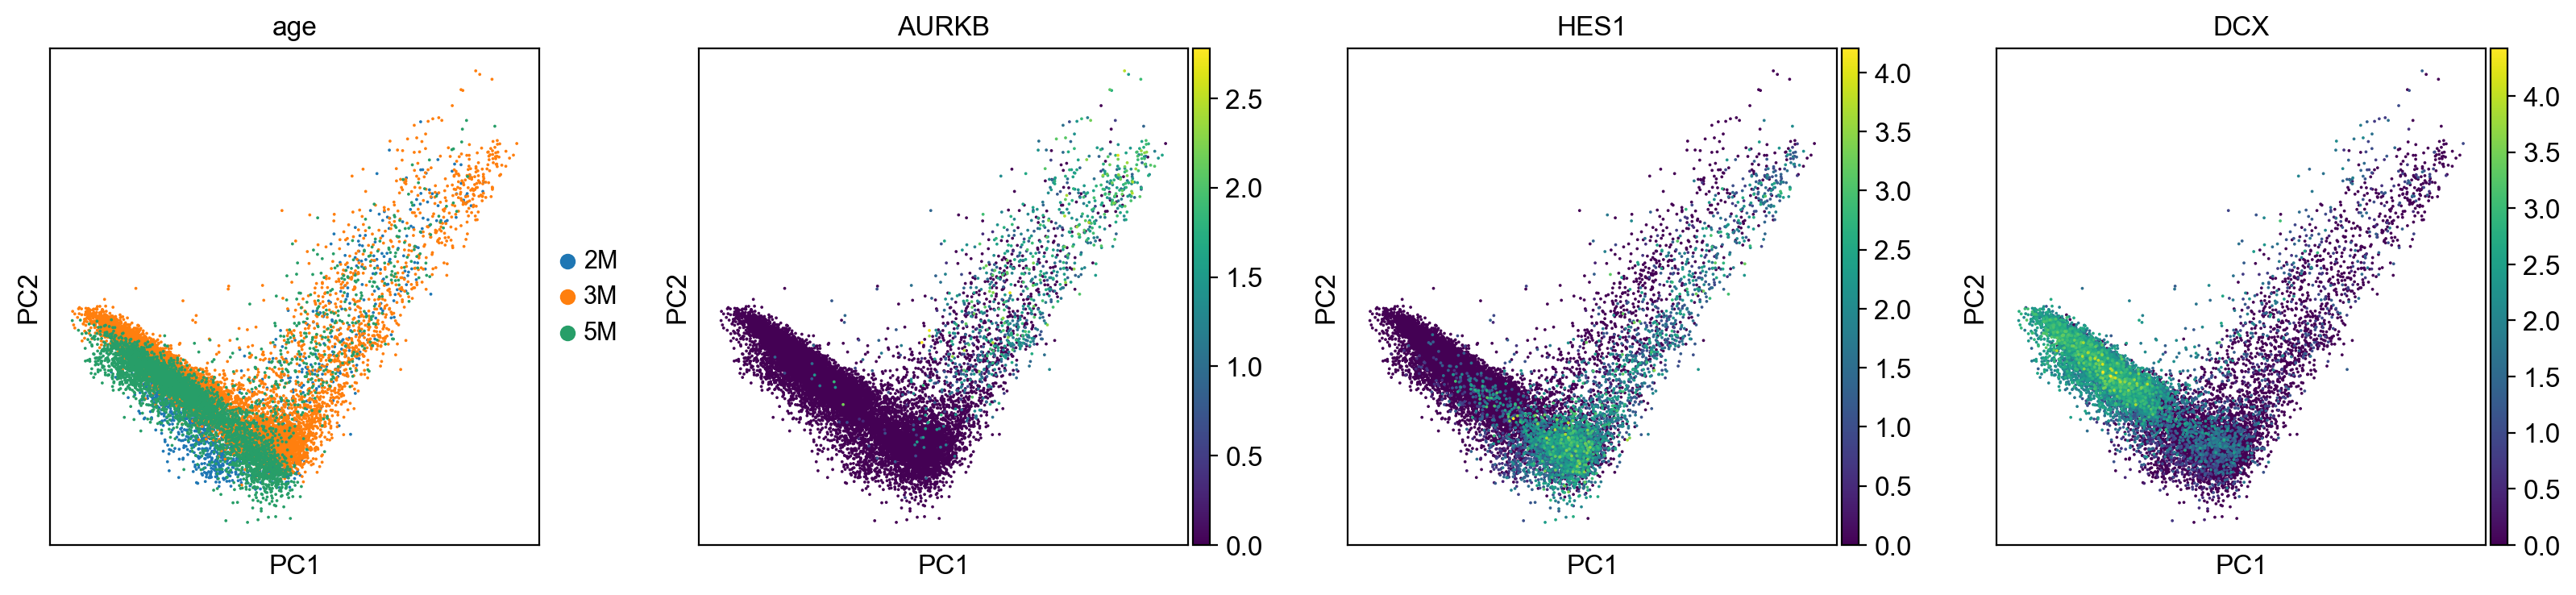

In [44]:
sc.pl.pca(adata, color=['age', 'AURKB','HES1','DCX'], cmap='viridis')

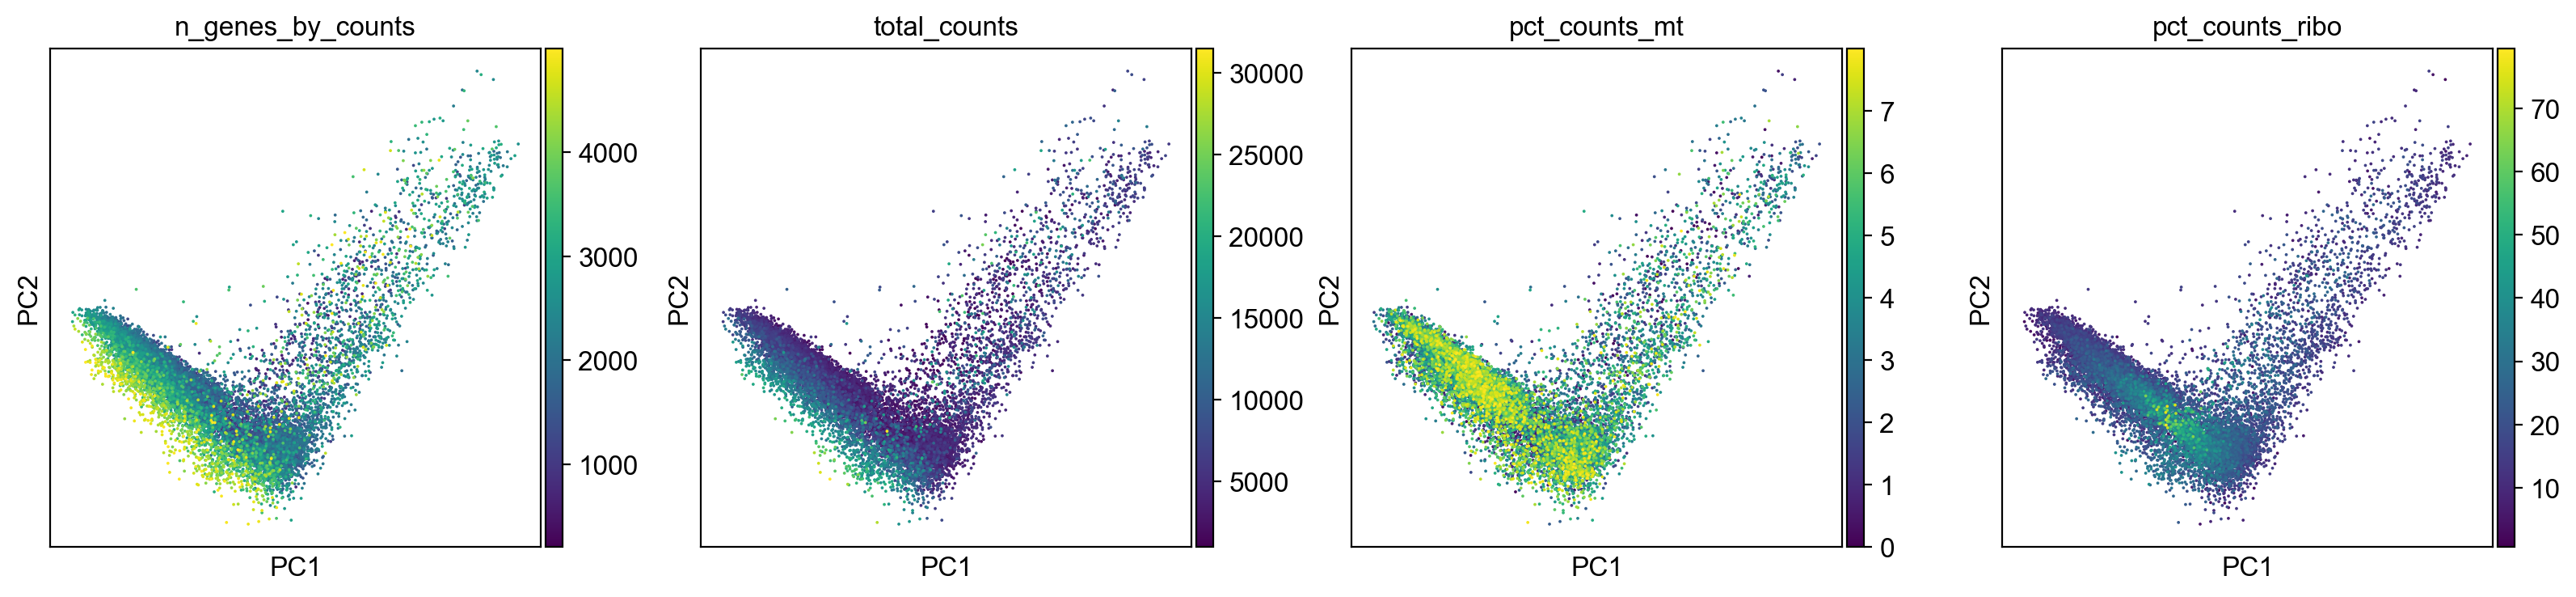

In [45]:
sc.pl.pca(adata, color=['n_genes_by_counts', 'total_counts', 'pct_counts_mt','pct_counts_ribo'], cmap='viridis')

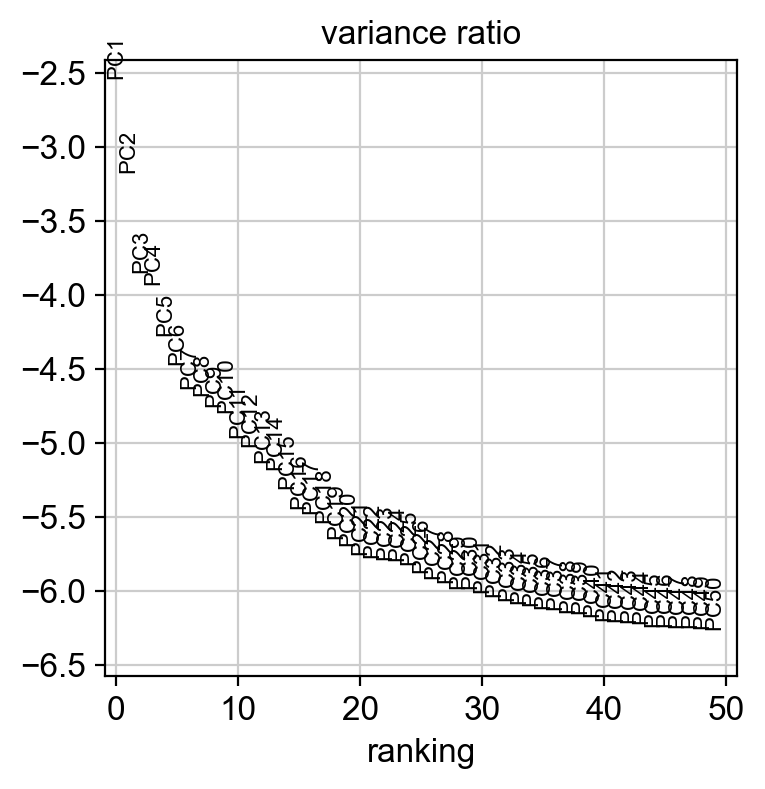

In [46]:
sc.pl.pca_variance_ratio(adata, log=True, n_pcs = 50)

In [47]:
#Plot loadings
# sc.pl.pca_loadings(adata, components=[1,2,3,4,5,6,7,8])

In [48]:
# Compute harmony_pca
sce.pp.harmony_integrate(adata, 'age')

2022-10-25 10:36:26,843 - harmonypy - INFO - Iteration 1 of 10
2022-10-25 10:36:41,144 - harmonypy - INFO - Iteration 2 of 10
2022-10-25 10:36:55,180 - harmonypy - INFO - Iteration 3 of 10
2022-10-25 10:37:09,872 - harmonypy - INFO - Iteration 4 of 10
2022-10-25 10:37:25,123 - harmonypy - INFO - Iteration 5 of 10
2022-10-25 10:37:40,737 - harmonypy - INFO - Converged after 5 iterations


In [49]:
processed_adata = './write/all_adata_processed.h5ad'

In [51]:
adata.write(processed_adata)